In [1]:
from __future__ import division

import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris

In [2]:
%matplotlib inline

In [8]:
iris = load_iris()
x_iris = iris['data']
y_iris = map(lambda x: np.array([1 if i == x else 0 for i in range(3)]),
        iris['target'])
y_iris = np.array(y_iris)

In [4]:
sigmoid = np.vectorize(lambda x: 1.0/(1.0+np.exp(-x)))
sig = lambda x: 1.0/(1.0+np.exp(-x))
sig_d = lambda x: sig(x) * (1 - sig(x))
sigmoid_d = np.vectorize(lambda x: sig(x) * (1 - sig(x)))

tanh_d = lambda x: 1 - np.square(np.tanh(x))

In [5]:
def log_loss(y, yhat):
    return np.sum(-(y*np.log(yhat) + (1 - y)*np.log(1 - yhat)))

In [11]:
class neural_network:
    
    def __init__(self, sizes, activation = sigmoid, act_d = sigmoid_d):
        '''
        one required arguement: a list with the layer sizes
        can be used for classification or regression
        '''
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(x) for x in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.a = [np.zeros(x) for x in sizes]
        self.a_vec = []
        self.activation = activation
        self.act_d = act_d
        self.z = [np.zeros(x) for x in sizes[1:]]
        self.z_vec = []
        
        
        
    def predict_vec(self,x):
        self.a_vec = [x]
        m = x.shape[0]
        biases = [np.matlib.repmat(b, m, 1) for b in self.biases]
        for w, b in zip(self.weights, biases):
            z = np.dot(w, x.T).T + b
            self.z_vec.append(z)
            x = sig(z)
            self.a_vec.append(x)
        
        return x      
        
        
    def predict(self, x):
        '''
        input:
            - x, a 2D numpy array
        output:
            predicted values
        '''
        out = []
        for i in x:
            for w, b in zip(self.weights, self.biases):
                i = self.activation(np.dot(w, i)+b)
                
            out.append(i)
            
        return np.array(out)
    
    
    def forward_prop(self, x):
        '''
        input:
            - x, a single observation
        output:
            predictions for x
            
        This method can be used for prediction, but it should only be used
        as part of training the neural network. The main difference is that
        forward_prop() records the activation vectors(a) and output vectors(z)
        '''
        self.a[0] = x
        for i, w in enumerate(self.weights):
            b = self.biases[i]
            self.z[i] = np.dot(w,x) + b
            x = self.activation(self.z[i])
            self.a[i+1] = x
            
            
        return self.a[-1]
                
    
    def gradient_descent(self, x, y, lr):
        m = len(x)
        delta_weights = [np.zeros((self.sizes[l+1], self.sizes[l]))
                 for l in range(len(self.sizes[:-1]))]

        delta_biases = [np.zeros(l) for l in self.sizes[1:]]

        for i in range(m):
            w_grads, b_grads = self.back_prop(x[i], y[i])
            delta_weights = [dw + wg for dw, wg in zip(delta_weights, w_grads)]
            delta_biases = [db + bg for db, bg in zip(delta_biases, b_grads)]
            
        
        self.weights = [w - lr * wg/m for
                        wg, w in zip(delta_weights, self.weights)]
        self.biases = [b - lr * bg/m for bg,b in zip(delta_biases, self.biases)]
        
    
#     def train(self, x, y, batch_size, learning_rate = 0.01, epochs, l2 = 1e-4): 
        
    
    def gradient_checking(self, x, y, epsilon):
        '''
        function to check the implementation of back_prop()
        '''
        original_weights = [l*1 for l in self.weights]
        grad_approx = [np.zeros((j, i)) 
                       for i, j in zip(self.sizes[:-1], self.sizes[1:])]
        w_grads, b_grads = self.back_prop(x, y)
        for l in xrange(self.num_layers - 1):
            lshape = self.weights[l].shape
            indicies = [(r, c) for c in xrange(lshape[1])
                       for r in xrange(lshape[0])]
            for i in indicies:
                self.weights[l][i] += epsilon
                theta_plus = log_loss(y, self.predict([x])[0])
                self.weights[l][i] -= 2*epsilon
                theta_minus = log_loss(y, self.predict([x])[0])
                grad_approx[l][i] = (theta_plus - theta_minus)/(2*epsilon)
                self.weights[l][i] += epsilon
                      
        b_grad_approx = [np.zeros(l) for l in self.sizes[1:]]
        original_biases = [b*1 for b in self.biases]
        for l in xrange(self.num_layers - 1):
            b_shape = len(self.biases[l])
            for i in xrange(b_shape):                
                self.biases[l][i] += epsilon
                theta_plus = log_loss(y, self.predict([x])[0])
                self.biases[l][i] -= 2*epsilon
                theta_minus = log_loss(y, self.predict([x])[0])
                b_grad_approx[l][i] = (theta_plus - theta_minus)/(2*epsilon)
                self.biases[l][i] += epsilon
        # print some information for gradient checking
        for l in xrange(self.num_layers - 1):
            print l
            print 'weights'
            print grad_approx[l]
            print w_grads[l]
            print 'difference'
            print grad_approx[l] - w_grads[l]
            print '----------------'
            print 'biases'
            print b_grad_approx[l]
            print b_grads[l]
            print 'difference'
            print b_grad_approx[l] - b_grads[l]
            print '_________________________________'  

    def back_prop(self, x, y):
        '''
        computes the gradients for gradient_descent
        '''
        nabla_w = [None for l in self.weights]
        nabla_b = [None for l in self.weights]
        deltas = [None for l in self.sizes]
        yhat = self.forward_prop(x)
        deltas[-1] = yhat - y
        for l in range(1, self.num_layers - 1)[::-1]:
            w = self.weights[l]
            a = self.a[l]
            z = self.z[l-1]
            deltas[l] = np.dot(w.T, deltas[l+1]) * self.act_d(z)
        for l in range(0, self.num_layers-1):
            nabla_w[l] =  np.outer(deltas[l+1], self.a[l].T)
            nabla_b[l] = deltas[l+1]
        return nabla_w, nabla_b


    def bp_vec(self, x, y):
        nabla_w = [None for l in self.weights]
        nabla_b = [None for l in self.weights]
        deltas = [None for l in self.sizes]
        yhat = self.predict_vec(x)
        deltas[-1] = yhat - y
        for l in range(1, self.num_layers - 1)[::-1]:
            w = self.weights[l]
            a = self.a_vec[l]
            z = self.z_vec[l-1]
            deltas[l] = (np.dot(w.T, deltas[l+1].T) * sig_d(z).T).T
        for l in range(0, self.num_layers-1):
            nabla_w[l] =  np.dot(deltas[l+1].T, self.a_vec[l])
            nabla_b[l] = deltas[l+1]
        return nabla_w, nabla_b

               
my_nn = neural_network([4,8,3])
bp_vecw, bp_vecb = my_nn.bp_vec(x_iris[:5], y_iris[:5])


# print bp_vecw
# print bpw
# bp_vecw[0] == bpw

In [15]:
x = np.array(range(20)[::-1])
y = np.array(range(20)[::-1])

m = len(x)

index = np.array(range(m))
np.random.shuffle(index)

batch_size = 8
print m/batch_size
num_batches = round(m/batch_size,0)
print num_batches
np.array_split(index, num_batches)

2.5
3.0


[array([ 3,  8, 16, 11, 10, 18, 15]),
 array([ 1,  5,  6,  2,  0,  9, 19]),
 array([12, 17, 14,  4,  7, 13])]

In [15]:
w.shape

(8L, 4L)

In [39]:
import numpy.matlib
np.matlib.repmat(np.random.randn(3), 9, 1)

array([[-0.85461502, -0.31632604, -1.27671658],
       [-0.85461502, -0.31632604, -1.27671658],
       [-0.85461502, -0.31632604, -1.27671658],
       [-0.85461502, -0.31632604, -1.27671658],
       [-0.85461502, -0.31632604, -1.27671658],
       [-0.85461502, -0.31632604, -1.27671658],
       [-0.85461502, -0.31632604, -1.27671658],
       [-0.85461502, -0.31632604, -1.27671658],
       [-0.85461502, -0.31632604, -1.27671658]])

In [27]:
sig(np.dot(w, np.random.randn(30, 4).T).T)

array([[  1.21948380e-01,   8.59006132e-01,   3.91307180e-01,
          4.71906659e-01,   6.49766459e-01,   2.35201531e-01,
          4.73742995e-01,   5.35409453e-01],
       [  3.04884003e-01,   9.71714292e-01,   1.34622117e-02,
          1.50664960e-01,   3.15845923e-02,   5.21526778e-02,
          8.29131295e-01,   2.38229331e-03],
       [  4.24496680e-01,   4.36094260e-01,   7.69358193e-01,
          3.61449598e-01,   5.53529453e-01,   1.95597158e-01,
          4.32612861e-01,   9.98429452e-01],
       [  9.65477893e-01,   2.94265051e-02,   5.53244535e-02,
          3.11988450e-01,   2.12791237e-01,   2.91425806e-01,
          5.95029697e-01,   1.55076824e-02],
       [  4.14971192e-01,   7.81680560e-01,   5.04221193e-01,
          3.52596977e-01,   2.37939245e-01,   3.11664184e-01,
          6.04624785e-01,   8.52887565e-01],
       [  9.99728001e-01,   1.19650641e-03,   9.98187057e-01,
          6.74835299e-01,   4.32459497e-02,   9.98751811e-01,
          5.92711999e-01,   9.9

In [7]:
# x_or = np.random.randint(2, size = (30,2))
x_or = np.array([[1,1], [1,0], [0,1], [0,0]])
y_or = np.array(map(lambda x: [(x[0]==1 or x[1]==1) and (x[0]!=1 or x[1]!= 1)],
                           x_or))

[[ 0.01027788]
 [ 0.98909645]
 [ 0.98908146]
 [ 0.01122895]]


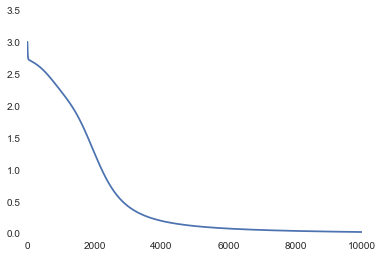

In [10]:
my_nn = neural_network([2,4,1])
cost = []
for i in xrange(10000):
    my_nn.gradient_descent(x_or, y_or, 0.1)
    cost.append(log_loss( y_or, my_nn.predict(x_or)))
    
print my_nn.predict(x_or)
plt.plot(cost)

[[  9.97019336e-01   3.70909096e-03   6.92049757e-05]
 [  9.96510516e-01   4.36764568e-03   7.60687200e-05]
 [  9.96926988e-01   3.90062610e-03   7.00883691e-05]
 [  9.96577631e-01   4.37212268e-03   7.36473885e-05]
 [  9.97095516e-01   3.66022952e-03   6.77296824e-05]
 [  9.97002148e-01   3.68555342e-03   6.91819783e-05]
 [  9.96998881e-01   3.86644011e-03   6.81410711e-05]
 [  9.96896552e-01   3.88006520e-03   7.06229181e-05]
 [  9.96406598e-01   4.64282958e-03   7.54481797e-05]
 [  9.96613757e-01   4.26113241e-03   7.45202609e-05]
 [  9.97043858e-01   3.63779581e-03   6.90556400e-05]
 [  9.96846706e-01   4.01898814e-03   7.03087314e-05]
 [  9.96622087e-01   4.27244355e-03   7.45181179e-05]
 [  9.97052057e-01   3.91780933e-03   6.78071933e-05]
 [  9.97161706e-01   3.44694094e-03   6.76561956e-05]
 [  9.97195652e-01   3.45081599e-03   6.66126774e-05]
 [  9.97135031e-01   3.50824202e-03   6.77759245e-05]
 [  9.96982617e-01   3.73476769e-03   6.97265221e-05]
 [  9.96939366e-01   3.72165

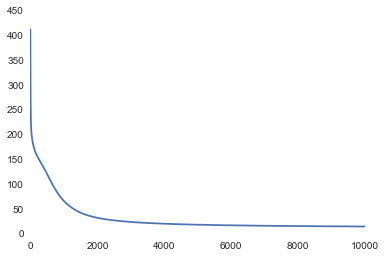

In [11]:
my_nn = neural_network([4,8,3])
cost = []
for i in xrange(10000):
    my_nn.gradient_descent(x_iris, y_iris, 0.1)
    cost.append(log_loss( y_iris, my_nn.predict(x_iris)))
    
print my_nn.predict(x_iris)
plt.plot(cost)